In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

In [2]:
path_datatest = "train"
lists_dir_datatest = os.listdir(path_datatest)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
    files = os.listdir(path_datatest +"/"+folder)
    for file in files:
        path_file = path_datatest + "/" + folder + "/" + file
        file_name_datatest.append(path_file)
        categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

,image,categories
1479,train/NonDemented/nonDem1637.jpg,NonDemented
4820,train/VeryMildDemented/verymildDem728.jpg,VeryMildDemented
3157,train/NonDemented/nonDem844.jpg,NonDemented
1917,train/NonDemented/nonDem2030.jpg,NonDemented
272,train/MildDemented/mildDem343.jpg,MildDemented
...,...,...
3983,train/VeryMildDemented/verymildDem1587.jpg,VeryMildDemented
2310,train/NonDemented/nonDem2385.jpg,NonDemented
388,train/MildDemented/mildDem448.jpg,MildDemented
878,train/NonDemented/nonDem1096.jpg,NonDemented


In [3]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    dataframe=data_datatest, 
    dir=path_datatest, 
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=(224,224),
    batch_size=64,
    shuffle=False
)

Found 5121 validated image filenames.


In [4]:
from keras.models import load_model
model = load_model('./model_tuning208_512_SGD1e2.h5')

In [5]:
predict= model.predict(test_generator, batch_size=64)
pred = np.argmax(predict, axis=1)

In [6]:
pred

array([2, 0, 3, ..., 0, 2, 0], dtype=int64)

In [7]:
true_classes=np.array(data_datatest['categories'].replace(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],[0,1,2,3,]))
true_classes

array([2, 3, 2, ..., 0, 2, 3], dtype=int64)

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(true_classes,pred)
cm

array([[ 564,    0,   74,   79],
       [  11,   29,    6,    6],
       [ 250,    0, 2223,   87],
       [ 462,    4,  620,  706]], dtype=int64)

In [9]:
class_labels=['0','1','2','3']
class_labels

['0', '1', '2', '3']

In [10]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, auc

In [11]:
report=metrics.classification_report(true_classes, pred,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.79      0.56       717
           1       0.88      0.56      0.68        52
           2       0.76      0.87      0.81      2560
           3       0.80      0.39      0.53      1792

    accuracy                           0.69      5121
   macro avg       0.72      0.65      0.65      5121
weighted avg       0.73      0.69      0.68      5121



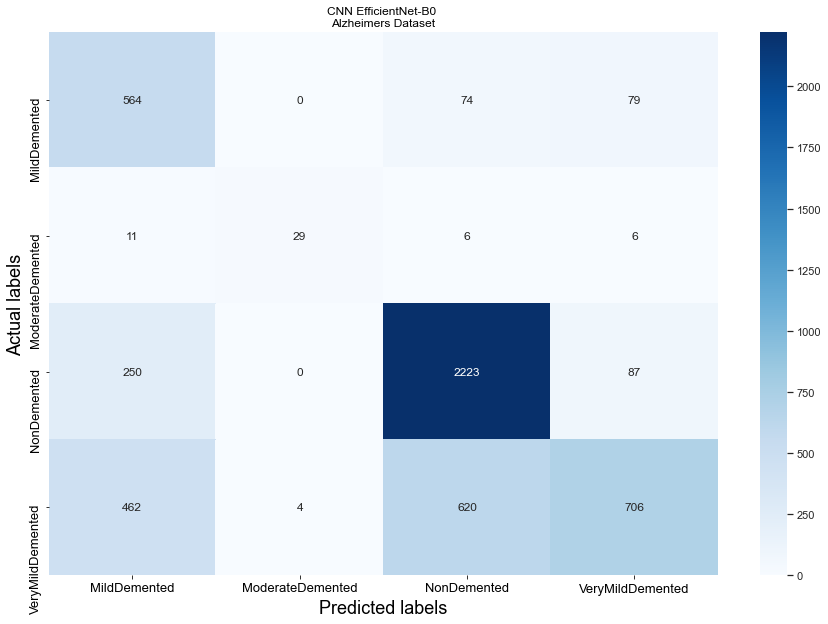

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
sns.set(font_scale=1.0) #edited as suggested
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Actual labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);
plt.title('CNN EfficientNet-B0 \nAlzheimers Dataset')

ax.tick_params(axis='both', which='major', labelsize=13)  # Adjust to fit
ax.xaxis.set_ticklabels(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']);
ax.yaxis.set_ticklabels(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']);